# Analysis of the allele screening results
---

This notebook evaluates the results of the specificity screen on an allele-level. For the screen we trained an Ensemble of two Resnet18 pretrained on the Imagenet data set that processed the individual single-nuclei images as well as whole FoV images. The latter model can use the whole FoV images to also derive distributional information like e.g. the cell density that might be helpful to distinguish the negative control setting from the OE condition.

We ran the specificity screen for 

## 0. Environmental setup

In [92]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import venn
from typing import List
from umap import UMAP
import os
from scipy.stats import pearsonr
from kneed import KneeLocator
from loess import loess_1d

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from statannot import add_stat_annotation

import sys

sys.path.append("../../../")

from src.utils.basic.io import get_file_list
from src.utils.notebooks.images.exp_evaluation import analyze_screen_results

%load_ext nb_black
%autosave 60

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


Autosaving every 60 seconds


<IPython.core.display.Javascript object>

In [93]:
def plot_spec_screen_results(
    root_dir: str,
    dataset_types: List[str],
    score_df: pd.DataFrame,
    label_col: str = "labels",
    figsize=[12, 6],
    filter_targets=None,
):
    subdirs = sorted(os.listdir(root_dir))
    for subdir in tqdm(subdirs, desc="Visualize latent spaces"):
        if filter_targets is None or subdir in filter_targets:
            fig, ax = plt.subplots(ncols=len(dataset_types), figsize=figsize)
            ax = ax.flatten()
            all_latents = []
            all_labels = []
            dataset_labels = []
            for i in range(len(dataset_types)):
                dataset_type = dataset_types[i]
                latents = pd.read_hdf(
                    os.path.join(root_dir, subdir, dataset_type + "_latents.h5")
                )
                all_labels.append(
                    np.array(
                        latents.loc[:, "labels"].map(
                            dict(zip([0, 1], sorted(["EMPTY", subdir.upper()])))
                        )
                    )
                )
                all_latents.append(np.array(latents.drop(columns=[label_col])))
                dataset_labels.extend([dataset_type] * len(latents))

            all_latents = np.concatenate(all_latents)
            all_labels = np.concatenate(all_labels)
            all_embs = TSNE(random_state=1234).fit_transform(all_latents)
            all_embs = pd.DataFrame(all_embs, columns=["tsne_0", "tsne_1"])
            all_embs["label"] = all_labels
            all_embs["dataset_type"] = np.array(dataset_labels)

            for i in range(len(dataset_types)):
                dataset_type = dataset_types[i]
                ax[i] = sns.scatterplot(
                    data=all_embs.loc[all_embs["dataset_type"] == dataset_type],
                    x="tsne_0",
                    y="tsne_1",
                    hue="label",
                    ax=ax[i],
                    hue_order=["EMPTY", subdir.upper()],
                    s=4,
                )
                score = score_df.loc[subdir.upper(), "{}_acc".format(dataset_type)]
                ax[i].set_title("{} data, acc: {:.4f}".format(dataset_type, score))
                ax[i].set_xlim([all_embs.tsne_0.min() - 20, all_embs.tsne_0.max() + 20])
                ax[i].set_ylim([all_embs.tsne_1.min() - 20, all_embs.tsne_1.max() + 20])

            fig.suptitle("Latent embeddings for {}".format(subdir))
            plt.show()
            plt.close()

<IPython.core.display.Javascript object>

In [94]:
cell_cycle_genes = set(
    pd.read_csv(
        "../../../data/other/reactome_cell_cycle.txt", index_col=0, header=None
    ).index
)
chrom_org_genes = set(
    pd.read_csv(
        "../../../data/other/reactome_chrom_org.txt", index_col=0, header=None
    ).index
)
dna_repair_genes = set(
    pd.read_csv(
        "../../../data/other/reactome_dna_repair.txt", index_col=0, header=None
    ).index
)
reg_actin_cytoskeleton_genes = set(
    pd.read_csv(
        "../../../data/other/kegg_reg_act_cytoskeleton.txt", index_col=0, header=None
    ).index
)
human_tfs = set(
    list(
        pd.read_csv(
            "../../../data/other/human_tf_list.txt", index_col=0, header=None
        ).index
    )
)
curated_gene_sets = (
    cell_cycle_genes.union(chrom_org_genes)
    .union(dna_repair_genes)
    .union(reg_actin_cytoskeleton_genes)
    .union(human_tfs)
)

<IPython.core.display.Javascript object>

In [95]:
rohban_target_set = pd.read_csv(
    "../../../data/other/rhoban_specific_orf_targets_alleles.csv", index_col=0
)
rohban_targets = set(rohban_target_set.index)

<IPython.core.display.Javascript object>

---

## 1. Read in data

First, we will read in the data which automatically scans the given directories of the individual screens for the corresponding log-files and extract the different scores from those.

In [96]:
screen_results = analyze_screen_results(
    "../../../data/experiments/image_embeddings/specificity_screen_alleles"
)

<IPython.core.display.Javascript object>

---

## 2. Analyses

### 2.1. Exploratory analyses

After having read in the data, we will first compute specificity score for each target that is given by the minimum of the validation and testing accuracy.

In [97]:
screen_results["min_val_test_acc"] = [
    np.min(screen_results.iloc[i, -2:]) for i in range(len(screen_results))
]

<IPython.core.display.Javascript object>

In [98]:
len(
    np.array(
        screen_results.sort_values("min_val_test_acc", ascending=False).min_val_test_acc
    )
)

322

<IPython.core.display.Javascript object>

Since, the input data was balanced by randomly undersampling the majority class, we expect a specificity score of around 0.5 to reflect random chance and hence no reproducible or no specific signal for the respective overexpression.

The plot below shows a rapid decrease in the specificity score for each of the different screening models using the morphological embeddings computed by Rohban et al. (2017), and the ResNet18 taking in the single nuclei images respectively a tuple of the single nuclei image and a patch centered at the single-nuclei location.

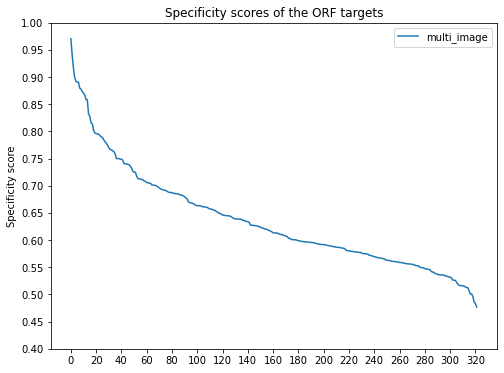

<IPython.core.display.Javascript object>

In [99]:
fig, ax = plt.subplots(figsize=[8, 6])


spec_scores = np.array(
    screen_results.sort_values("min_val_test_acc", ascending=False).min_val_test_acc
)
idx = np.array(list(range(len(spec_scores))))

plt.plot(idx, spec_scores, label="multi_image")
plt.title("Specificity scores of the ORF targets")
plt.xticks(np.arange(0, len(spec_scores), 20))
plt.yticks(np.arange(40, 105, 5) / 100)
plt.ylabel("Specificity score")
plt.legend()
plt.show()

We see that all of the curves show a fairly similar shape while the multi-image setup yields on average significantly higher scores. The comparability of the scores is also apparent when looking at the correlation of the individual specificity scores for any pair of the screening models.

---

## 3. Validation of the specificity scores

Before we proceed further, we aim to validate our definition of the specifity score. To this end, we will look at the distribution of the respective score (from now on focussing on the multi-image input model-based screen) in different gene sets, i.e. one that describes the 110 alleles that were identified as yielding specific and reproducible structural phenotypes upon overexpression of corresponding alleles in the study by Rohban et al. (2017) as well as a set obtained from the curation of multiple pathways that are expected to modulate the chromatin organization and cellular morphology.

In [100]:
spec_results = screen_results.copy()
spec_results.index = spec_results.target
spec_results["spec_score"] = spec_results.min_val_test_acc

<IPython.core.display.Javascript object>

In [101]:
spec_results["rohban_selected"] = np.array(
    spec_results.index.isin(rohban_targets)
).astype("str")

for allele in spec_results.index:
    spec_results.loc[allele, "mechano_pathways"] = (
        allele.split("-")[0] in curated_gene_sets
    )
spec_results["mechano_pathways"] = np.array(spec_results.mechano_pathways).astype(str)

<IPython.core.display.Javascript object>

False v.s. True: Mann-Whitney-Wilcoxon test smaller with Bonferroni correction, P_val=1.236e-10 U_stat=6.605e+03
False v.s. True: Mann-Whitney-Wilcoxon test smaller with Bonferroni correction, P_val=2.397e-04 U_stat=9.900e+03


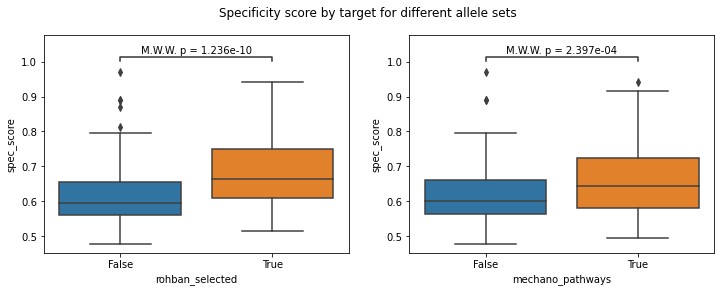

<IPython.core.display.Javascript object>

In [102]:
fig, ax = plt.subplots(ncols=2, figsize=[12, 4])
ax = ax.flatten()
ax[0] = sns.boxplot(
    data=spec_results,
    y="spec_score",
    x="rohban_selected",
    ax=ax[0],
    order=["False", "True"],
)
add_stat_annotation(
    ax[0],
    data=spec_results,
    x="rohban_selected",
    y="spec_score",
    box_pairs=[("True", "False")],
    test="Mann-Whitney-ls",
    text_format="full",
    loc="inside",
    order=["False", "True"],
)
ax[1] = sns.boxplot(
    data=spec_results,
    y="spec_score",
    x="mechano_pathways",
    ax=ax[1],
    order=["False", "True"],
)
add_stat_annotation(
    ax[1],
    data=spec_results,
    x="mechano_pathways",
    y="spec_score",
    box_pairs=[("False", "True")],
    test="Mann-Whitney-ls",
    loc="inside",
    text_format="full",
    order=["False", "True"],
)
fig.suptitle("Specificity score by target for different allele sets")
plt.show()

As seen above the specificity score is significantly higher for targets that are part of the mechano-transduction pathways and for the targets selected in Rohban et al. 2017.

However, we will further assess the set of targets that Rohban selected and look at the respective specificity scores for those.

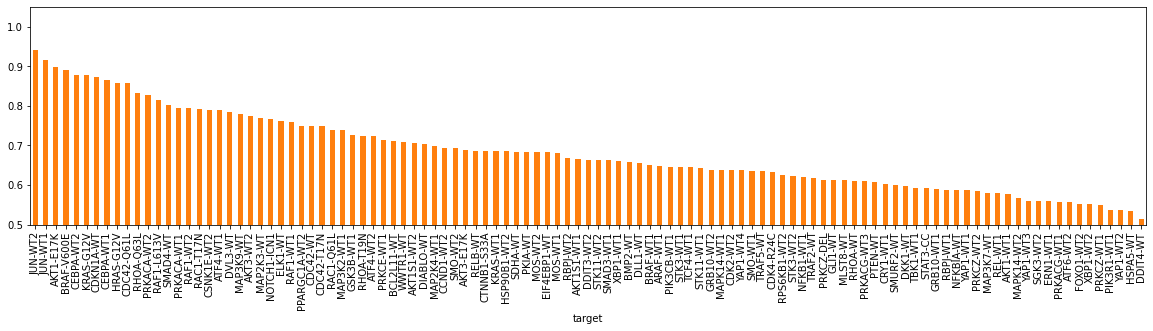

<IPython.core.display.Javascript object>

In [103]:
spec_rohban = spec_results.loc[spec_results.rohban_selected == "True", :]

ax = spec_rohban.sort_values("spec_score", ascending=False).spec_score.plot.bar(
    figsize=[20, 4], color="tab:orange"
)
ax.set_ylim([0.5, 1.05])
plt.show()

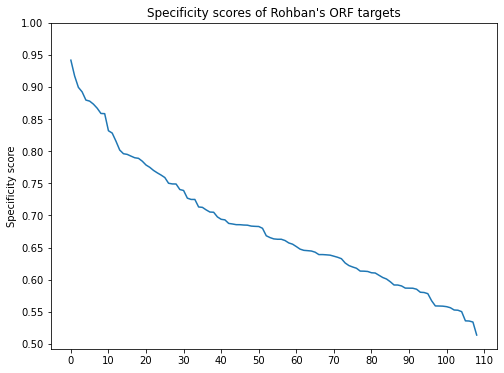

<IPython.core.display.Javascript object>

In [104]:
fig, ax = plt.subplots(figsize=[8, 6])


spec_scores_rohban = np.array(
    spec_rohban.sort_values("min_val_test_acc", ascending=False).spec_score
)
idx = np.array(list(range(len(spec_scores_rohban))))

plt.plot(idx, spec_scores_rohban)
plt.title("Specificity scores of Rohban's ORF targets")
plt.xticks(np.arange(0, len(spec_scores_rohban) + 5, 10))
plt.yticks(np.arange(50, 105, 5) / 100)
plt.ylabel("Specificity score")
plt.show()

We see that for most of the ORF targets we obtain relatively high specificity scores as e.g. 85/110 (77.98%) of the OE conditions yield a specificity score of above 0.6. However, there are also a few targets that do not yield high specifity scores. This can be explained that in the study by Rohban et al. not only the DNA images but also fluorescent images of the same cells providing information regarding e.g. the mitochondria, the cell membrane or the Golgi were used. In the publication the fact that features computed from those channels are the most important ones for one chosen cluster suggest that this might be the explanation why e.g. we do not see any significant change in the nuclear geometry or chromatin organization when looking at e.g. DDIT4 overexpression of the wildtype allele 1.

In [105]:
np.sum(spec_rohban.spec_score >= 0.6)

85

<IPython.core.display.Javascript object>